In [1]:
import os, sys, time
# Reference: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload

import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score


import common
import DimensionalityReduction.DimensionalityReductionDatasets as dr_datasets
from data.generated.generated_data import get_noisy_nonlinear_with_non_noisy_labels

title_fontsize = 24
fontsize = 24
legend_fontsize = 18
default_figure_size = (15, 8)

DATASET = "Generated Non-Linear"

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
X_train_gnnl, X_test_gnnl, y_train_gnnl, y_test_gnnl, y_test_non_noisy_gnnl =\
get_noisy_nonlinear_with_non_noisy_labels()

reload(dr_datasets)
random_gnnl,_ = dr_datasets.get_gnnl_random_projection()

/home/richard/.virtualenvs/computervision/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
random_gnnl.shape[1]

5

In [8]:
reload(common)
n = random_gnnl.shape[1]
distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times =\
common.compute_kmeans_scores(random_gnnl, n)

For n_clusters = 2 average silhouette_score: 0.7057452683164694 time taken: 0.1478862762451172s
For n_clusters = 3 average silhouette_score: 0.565544927781988 time taken: 0.09398412704467773s
For n_clusters = 4 average silhouette_score: 0.3661488066217318 time taken: 0.0876607894897461s
For n_clusters = 5 average silhouette_score: 0.4169292411438431 time taken: 0.11340022087097168s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


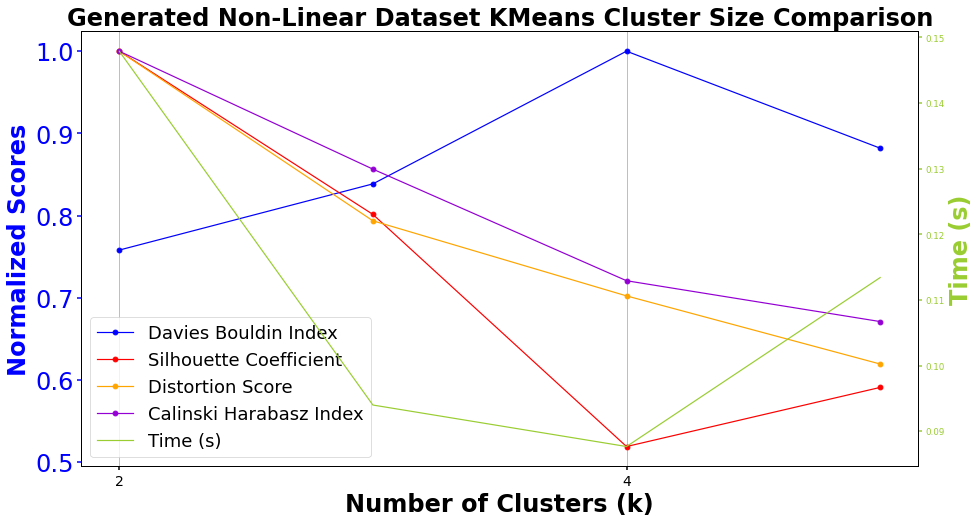

In [9]:
common.plot_kmeans_all(distortions, davies_bouldin_scores, silhouette_scores, calinski_harabasz_scores, times, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:109: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


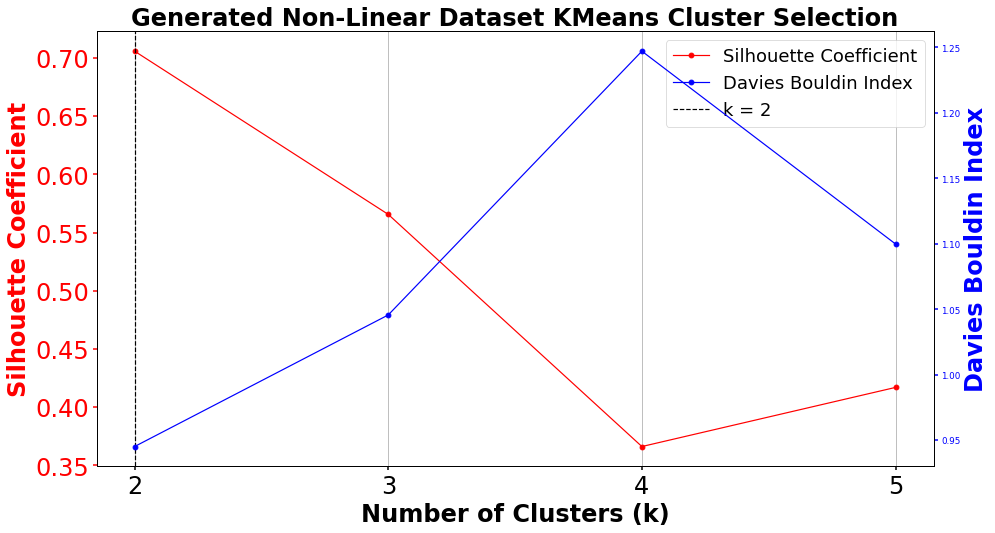

In [10]:
reload(common)
best_k = 2
common.plot_kmeans_selection(davies_bouldin_scores, silhouette_scores, best_k=best_k, DATASET=DATASET, tick_spacing=1)

For n_clusters = 2 average silhouette_score: 0.7057452683164694 time taken: 0.24377846717834473s


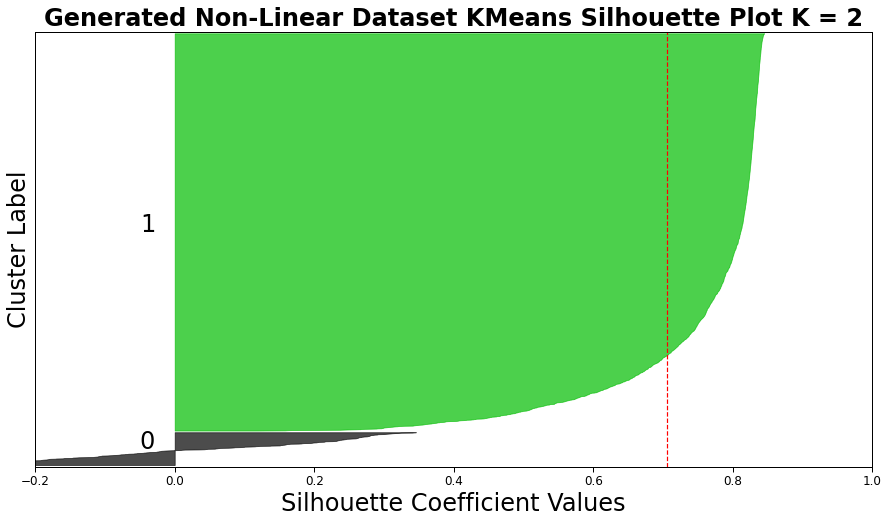

In [11]:
reload(common)
common.plot_silhouette_kmeans(random_gnnl, best_k, DATASET, xlim=[-0.2, 1.0])

In [32]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
km = KMeans(n_clusters=best_k, **common.km_arguements)
km.fit(random_gnnl)
end_time = time.time()
print("Time Taken {} s".format(end_time - start_time))
y_train_gnnl_df['km_labels']=km.labels_
random_gnnl_km = pd.DataFrame(random_gnnl.copy())
random_gnnl_km['km_labels'] = km.labels_
random_gnnl_km['data_labels'] = y_train_gnnl

print("homogeneity_score: ", homogeneity_score(km.labels_, y_train_gnnl))

Time Taken 0.14492344856262207 s
homogeneity_score:  0.0011795921490797311


In [33]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(random_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

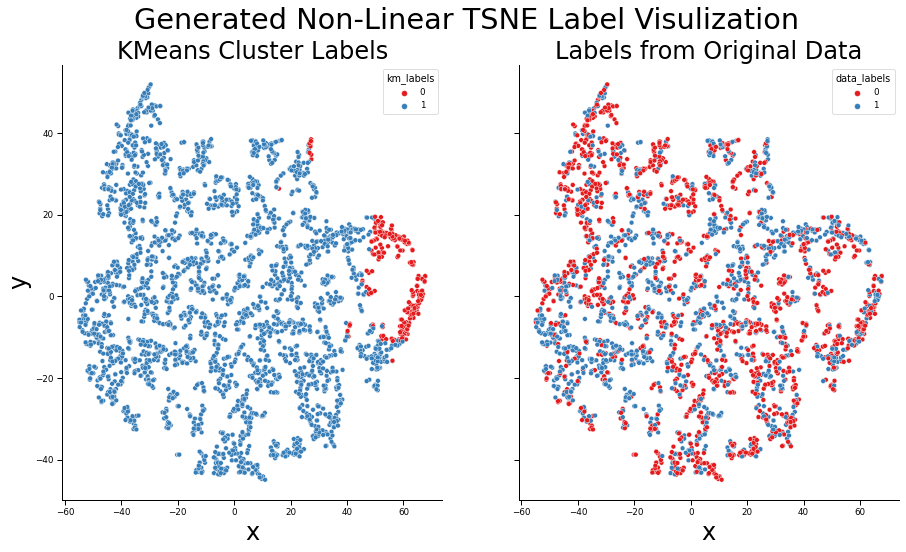

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="km_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("KMeans Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

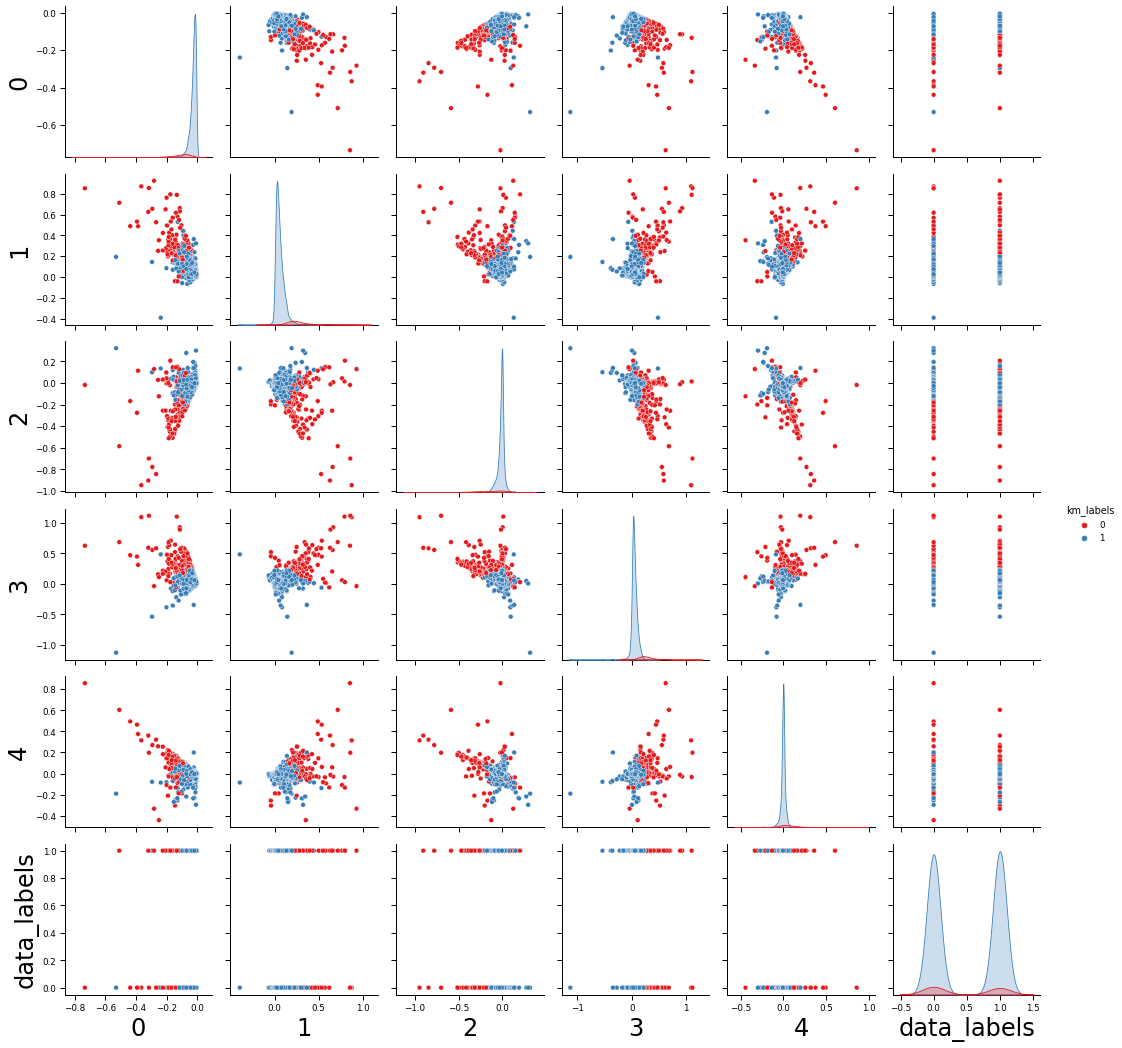

In [35]:
sns.pairplot(random_gnnl_km, hue="km_labels", palette="Set1")

# Expectation Maximization

In [16]:
reload(common)
em_n = random_gnnl.shape[1]
n_components = np.arange(2, em_n)
davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em =\
common.compute_em_scores(random_gnnl, em_n)

For n_clusters = 2 average silhouette_score: 0.49363564338901367 time taken: 0.13808488845825195s
For n_clusters = 3 average silhouette_score: 0.2369974607985523 time taken: 0.20327186584472656s
For n_clusters = 4 average silhouette_score: 0.208697106988581 time taken: 0.20328211784362793s
For n_clusters = 5 average silhouette_score: 0.07926486433024027 time taken: 0.3004326820373535s


/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:250: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


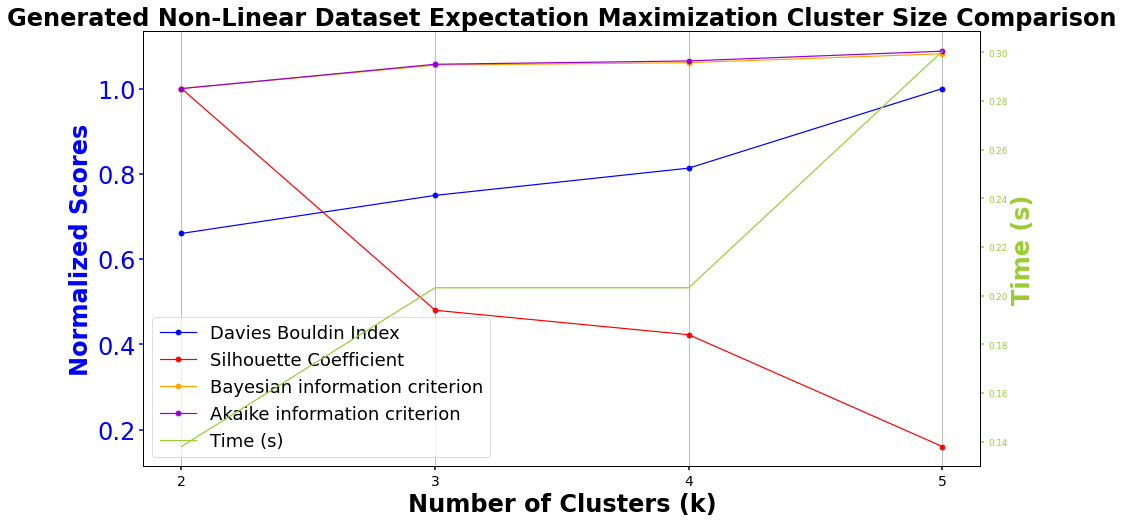

In [17]:
reload(common)
common.plot_em_all(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, times_em, DATASET)

/media/richard/Data/CloudStation/Masters Degree/GATechOMSCS_CourseWork/CS7641-Machine_Learning/UnsupervisedLearning_Project_Code/common.py:301: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  host = fig.add_subplot(111)


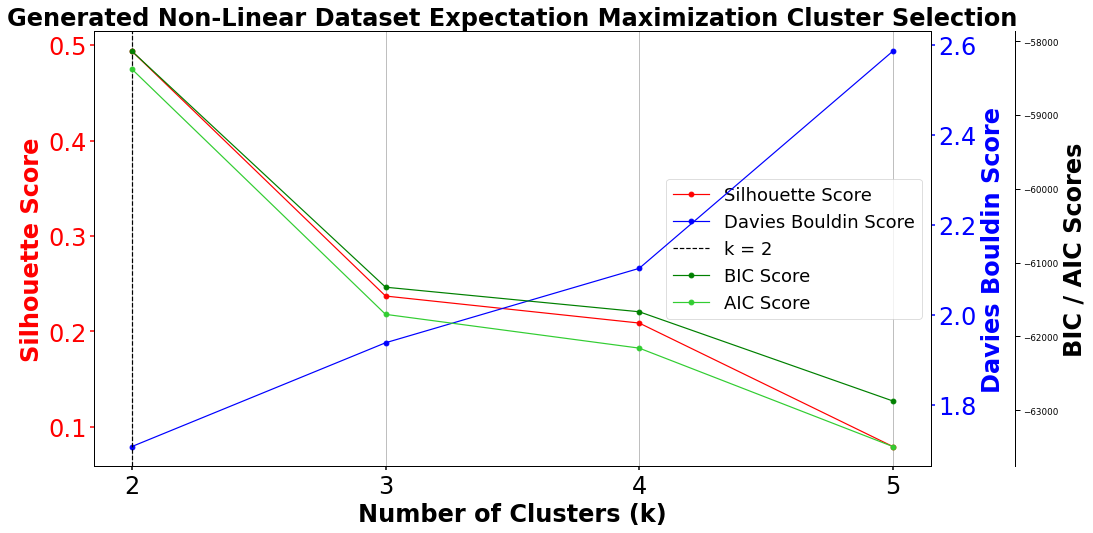

In [18]:
reload(common)
best_k = 2
common.plot_em_selection(davies_bouldin_scores_em, silhouette_scores_em, bic_scores_em, aic_scores_em, best_k, DATASET, tick_spacing=1)

For n_clusters = 2 average silhouette_score: 0.49363564338901367 time taken: 0.15802001953125s


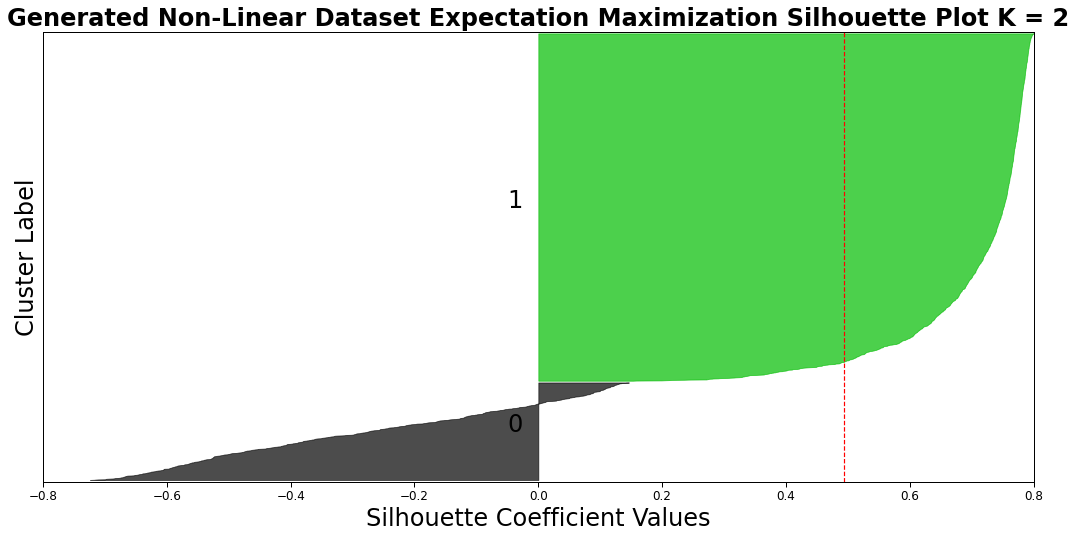

In [19]:
reload(common)
best_k=2
common.plot_silhouette_em(random_gnnl, best_k, DATASET, xlim=[-0.8, 0.8])

In [28]:
y_train_gnnl_df = pd.DataFrame(y_train_gnnl, columns=["data_labels"])

start_time = time.time()
em_model = GaussianMixture(best_k, **common.em_arguements)
em_model.fit(random_gnnl)
end_time = time.time()
print("time taken {} s".format(end_time-start_time))
y_train_gnnl_df['em_labels']=em_model.predict(random_gnnl)
random_gnnl_em = pd.DataFrame(random_gnnl.copy())
random_gnnl_em['em_labels'] = em_model.predict(random_gnnl)
random_gnnl_em['data_labels'] = y_train_gnnl


print("homogeneity_score: ", homogeneity_score(em_model.predict(random_gnnl), y_train_gnnl))


time taken 0.16386914253234863 s
homogeneity_score:  0.008322337107137145


In [29]:
# Create a t-SNE model with learning rate 50
m = TSNE(perplexity=30, learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(random_gnnl)
y_train_gnnl_df['x'] = tsne_features[:,0]
y_train_gnnl_df['y'] = tsne_features[:,1]

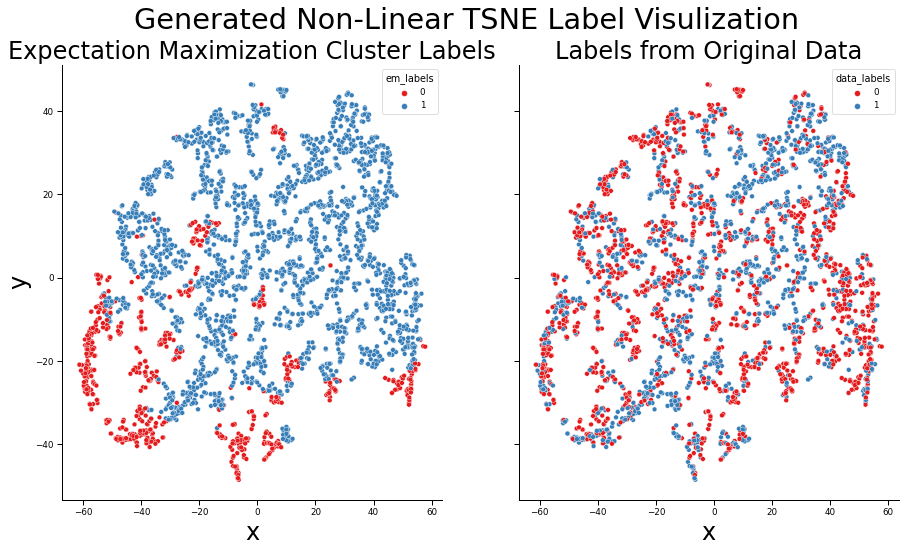

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=default_figure_size, sharey=True)

sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

sns.scatterplot(x="x", y="y", hue="em_labels", data=y_train_gnnl_df, palette="Set1", ax=ax1)
sns.scatterplot(x="x", y="y", hue="data_labels", data=y_train_gnnl_df, palette="Set1", ax=ax2)

fig.suptitle("{} TSNE Label Visulization".format(DATASET))
ax1.set_title("Expectation Maximization Cluster Labels")
ax2.set_title("Labels from Original Data")
sns.despine(fig)

plt.show()

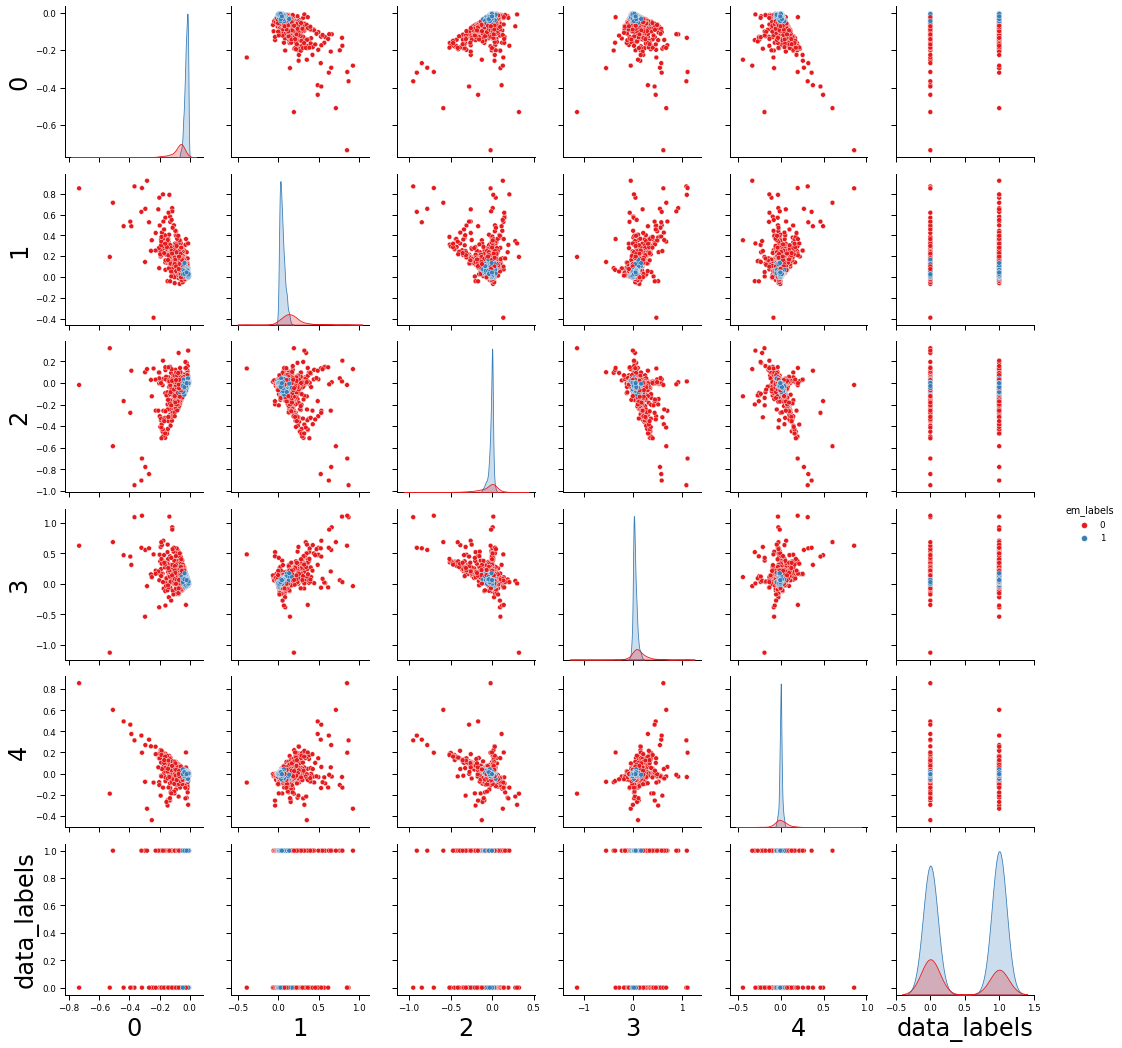

In [31]:
sns.pairplot(random_gnnl_em, hue="em_labels", palette="Set1")